In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 
pd.options.display.float_format = '{:,.2f}'.format

start = time.perf_counter()

In [3]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv') 
# df = pd.read_csv('jammedaxis27109-infinite-matchhistory.csv')
# df.info()
# df.describe().transpose()

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] > '2024-02-04']

df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)

dfr = df[df['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
# dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
# dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0, 'Draw': 0.5})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                           (dfr['Outcome'].cumsum() + 
                            dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('dfNS.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               158 non-null    int64         
 1   Date                158 non-null    datetime64[ns]
 2   SeasonNumber        158 non-null    int64         
 3   SeasonVersion       158 non-null    int64         
 4   Map                 158 non-null    object        
 5   Category            158 non-null    object        
 6   Rank                158 non-null    int64         
 7   Outcome             158 non-null    float64       
 8   Accuracy            158 non-null    float64       
 9   DamageDone          158 non-null    int64         
 10  DamageTaken         158 non-null    int64         
 11  ShotsFired          158 non-null    int64         
 12  ShotsLanded         158 non-null    int64         
 13  ShotsMissed         158 non-null    int64         

In [5]:
dfr.tail(2)

,index,Date,SeasonNumber,SeasonVersion,Map,Category,Rank,Outcome,Accuracy,DamageDone,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
156,863,2024-03-12 02:18:30,6,1,Streets,Slayer,4,1.00,56.64,3898,...,1.14,1.19,52.33,26.57,9.28,54.36,6.94,2.85,1085,0.60
157,864,2024-03-12 02:26:23,6,1,Recharge,King of the Hill,2,1.00,57.48,7993,...,1.14,1.19,52.37,26.58,9.32,54.23,7.04,2.83,1091,0.60


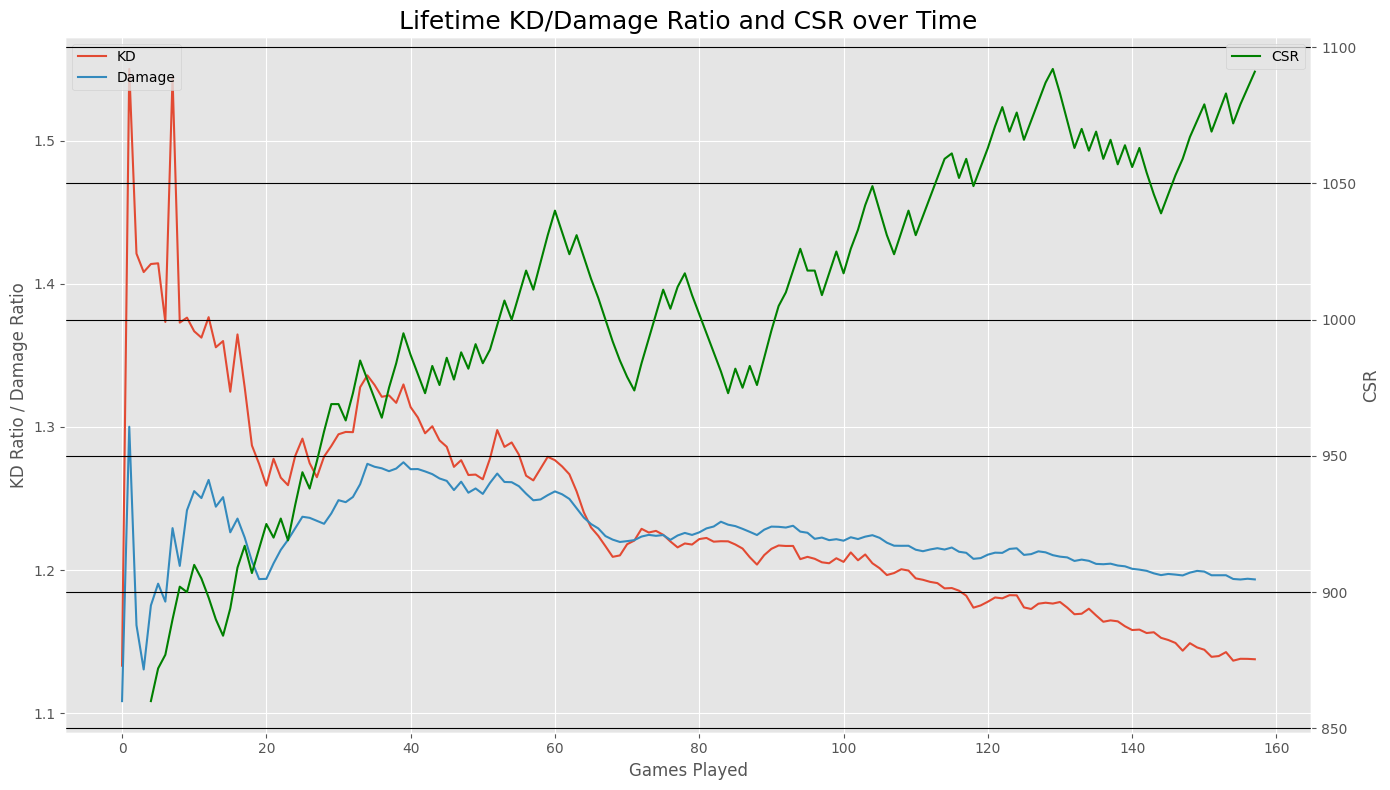

In [6]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][4:], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True, color='black')
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

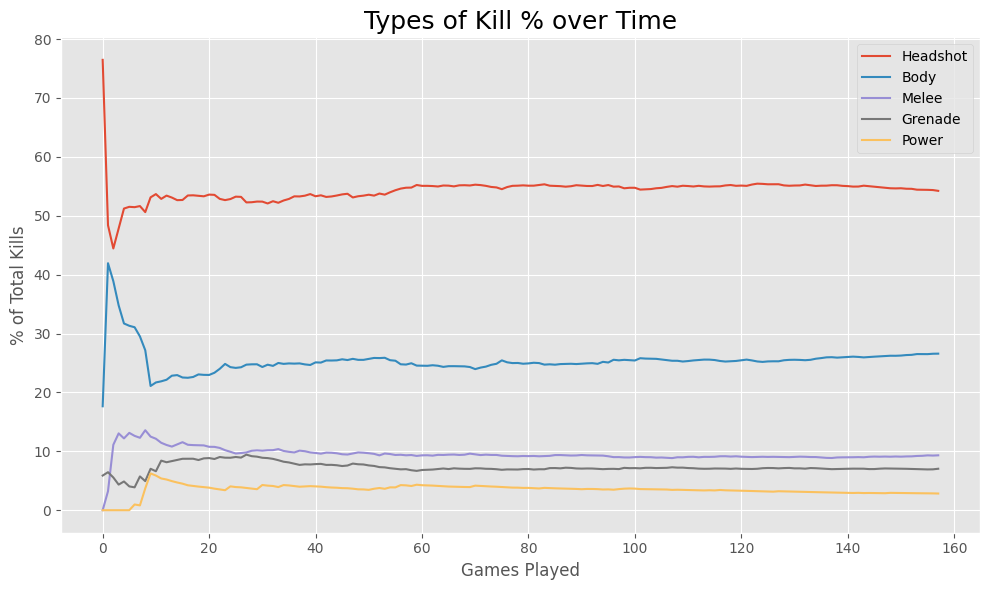

In [7]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeHSPct'], label='Headshot')
plt.plot(dfr['LifetimeBodyPct'], label='Body')
plt.plot(dfr['LifetimeMeleePct'], label='Melee')
plt.plot(dfr['LifetimeGrenadePct'], label='Grenade')
plt.plot(dfr['LifetimePowerPct'], label='Power')
plt.title('Types of Kill % over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
plt.legend(loc='best')
plt.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

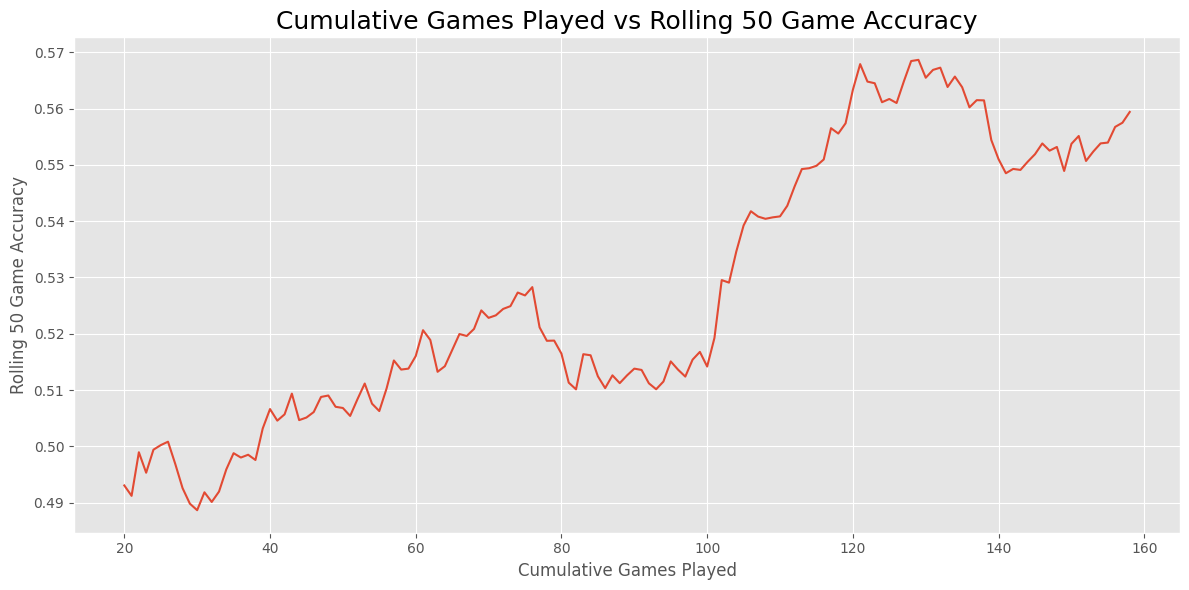

In [8]:
mod = 20

# Line graph of cumulative games played and rolling 50 game accuracy
dfr['CumulativeGames'] = np.arange(1, len(dfr) + 1)
dfr['RollingAccuracy'] = dfr['ShotsLanded'].rolling(window=mod).sum() / dfr['ShotsFired'].rolling(window=mod).sum()

plt.figure(figsize=(12, 6))
plt.plot(dfr['CumulativeGames'], dfr['RollingAccuracy'])
plt.title('Cumulative Games Played vs Rolling 50 Game Accuracy', fontsize=18)
plt.xlabel('Cumulative Games Played')
plt.ylabel('Rolling 50 Game Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


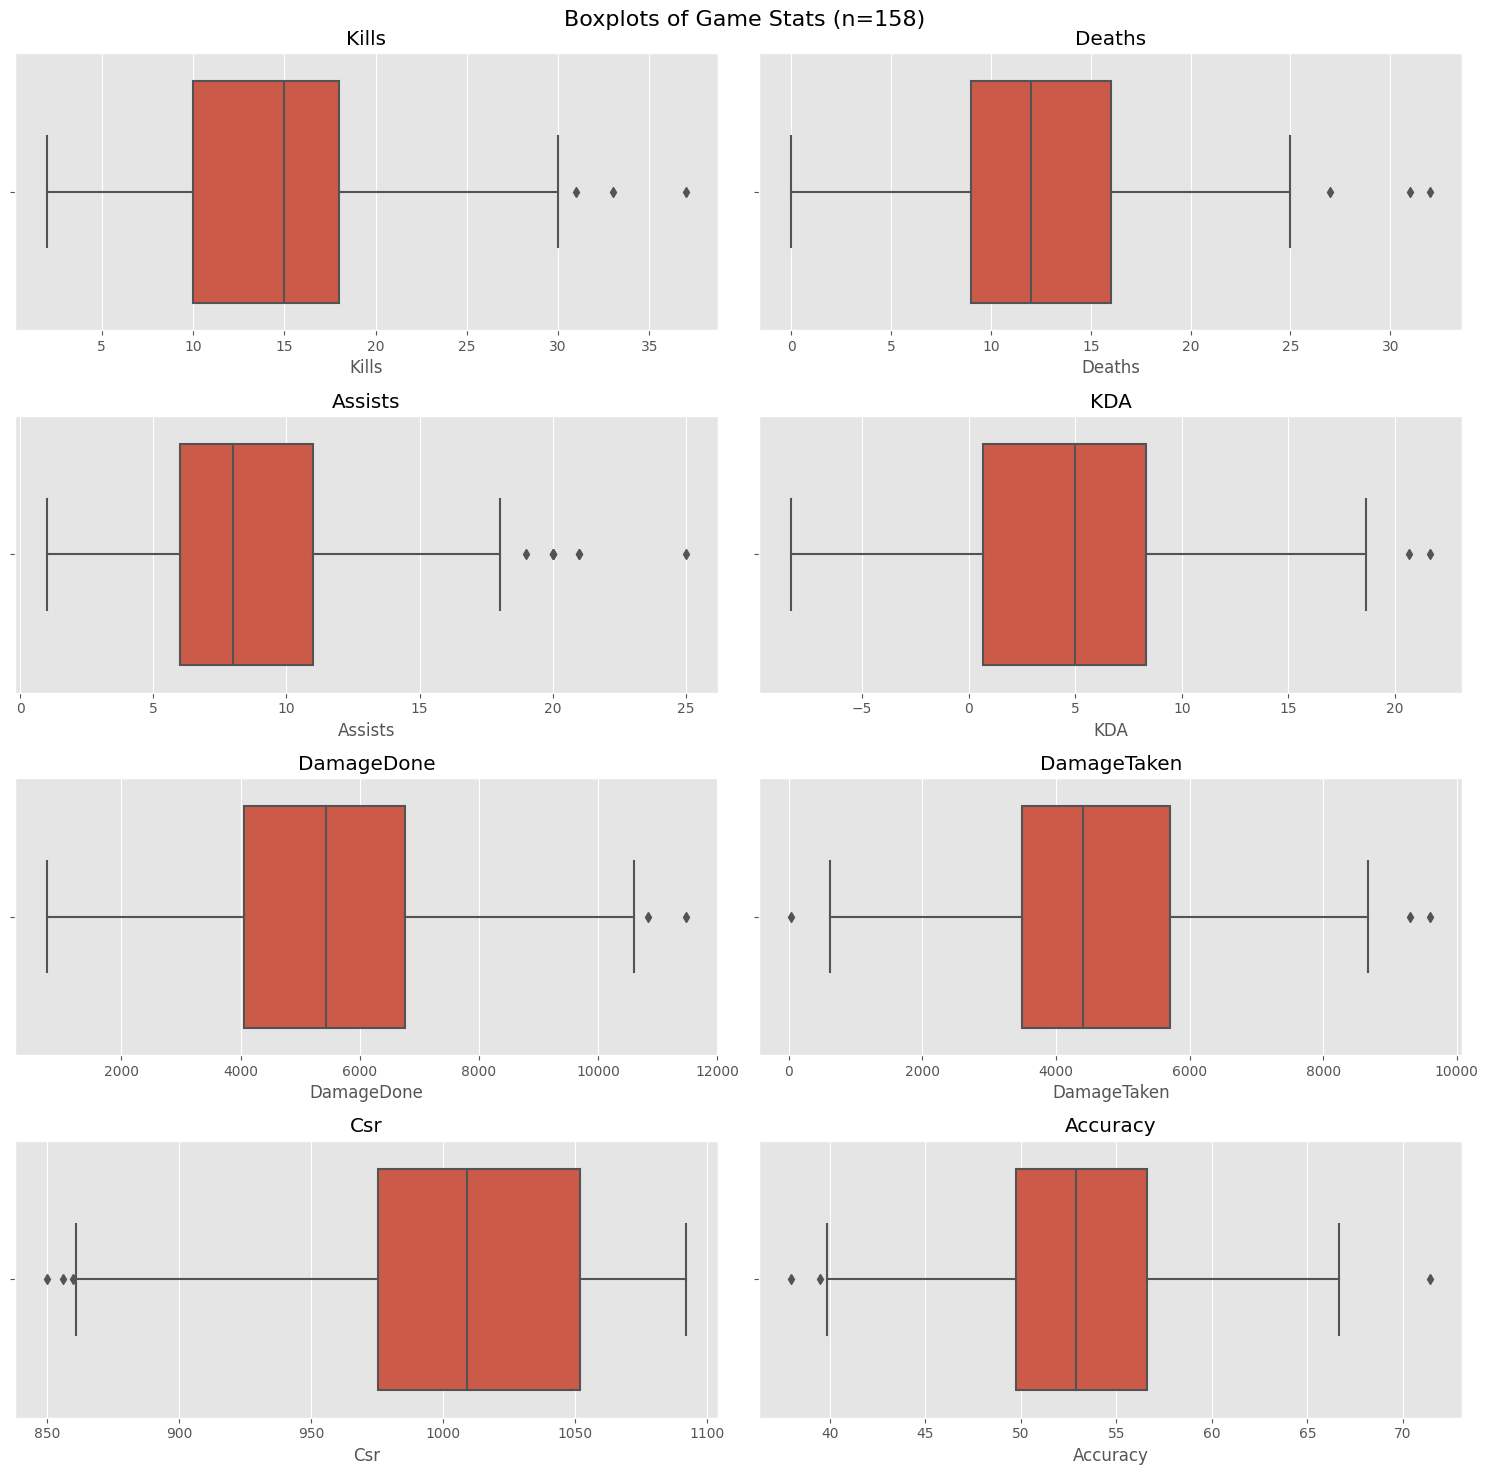

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle(f'Boxplots of Game Stats (n={len(dfr)})', fontsize=16)
plt.tight_layout()
# plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [18]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Category', 'Map'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Dmg/KA', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
Slayer           Aquarius       5     41      52       38       20336   
CTF 3 Captures   Empyrean      17    291     267      127      105332   
                 Forbidden     13    147     105       76       55064   
Slayer           Streets        8     67      76       54       29725   
CTF 3 Captures   Argyle        14    213     183      105       77755   
King of the Hill Live Fire      3     47      48       33       19384   
Strongholds      Recharge       4     64      50       32       23015   
Slayer           Recharge       3     33      25       11       10514   
CTF 5 Captures   Aquarius      13    233     171      127       83782   
Oddball          Live Fire      8    132     153       93       51789   
Strongholds      Live Fire      8    137     109       69       47340   
King of the Hill Recharge      13    194     181      152       78719   
Oddball          Streets        8    143     117       77       48793   
Slayer           Live Fire      8     84      76       53       30215   
King of the Hill Solitude       9    136     126      101       51536   
Slayer           Solitude       9     98      82       77       37005   
Oddball          Recharge       8    140     111      100       49393   
Strongholds      Solitude       7    132      95       81       42228   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
Slayer           Aquarius         19195     0.40          41.20     52.85   
CTF 3 Captures   Empyrean         94729     0.44         213.07     51.87   
                 Forbidden        39707     0.69         114.33     51.84   
Slayer           Streets          27356     0.38          65.28     52.48   
CTF 3 Captures   Argyle           61991     0.43         158.35     52.30   
King of the Hill Live Fire        16726     1.00          37.50     53.19   
Strongholds      Recharge         19774     0.50          49.35     49.51   
Slayer           Recharge          9196     0.67          25.57     46.69   
CTF 5 Captures   Aquarius         63507     0.62         143.15     54.15   
Oddball          Live Fire        49003     0.62         108.90     54.16   
Strongholds      Live Fire        38886     0.50          94.02     57.17   
King of the Hill Recharge         66264     0.31         144.38     50.78   
Oddball          Streets          39561     1.00          96.10     54.36   
Slayer           Live Fire        27332     0.88          67.35     54.28   
King of the Hill Solitude         42958     0.67         101.68     53.10   
Slayer           Solitude         31268     0.78          77.98     49.66   
Oddball          Recharge         38917     0.75          96.00     52.93   
Strongholds      Solitude         34628     0.71          80.27     54.24   

                             KD  DamageRatio  Dmg/Life  Dmg/KA  ExDmg/Life  \
Category         Map                                                         
Slayer           Aquarius  0.79         1.06    391.08  257.42       21.94   
CTF 3 Captures   Empyrean  1.09         1.11    394.50  251.99       39.71   
                 Forbidden 1.40         1.39    524.42  246.92      146.26   
Slayer           Streets   0.88         1.09    391.12  245.66       31.17   
CTF 3 Captures   Argyle    1.16         1.25    424.89  244.51       86.14   
King of the Hill Live Fire 0.98         1.16    403.83  242.30       55.38   
Strongholds      Recharge  1.28         1.16    460.30  239.74       64.82   
Slayer           Recharge  1.32         1.14    420.56  238.95       52.72   
CTF 5 Captures   Aquarius  1.36         1.32    489.95  232.73      118.57   
Oddball          Live Fire 0.86         1.06    338.49  230.17       18.21   
Strongholds      Live Fire 1.26         1.22    434.31  229.81       77.56   
King of the 

In [16]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,Dmg/KA,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,
Oddball,24,415,381,270,149975,127481,0.79,1.09,1.18,393.64,218.94,59.04,0.71
Slayer,33,323,311,233,127795,114347,0.64,1.04,1.12,410.92,229.85,43.24,0.75
CTF 5 Captures,13,233,171,127,83782,63507,0.62,1.36,1.32,489.95,232.73,118.57,0.74
Strongholds,19,333,254,182,112583,93288,0.58,1.31,1.21,443.24,218.61,75.96,0.72
King of the Hill,25,377,355,286,149639,125948,0.52,1.06,1.19,421.52,225.70,66.74,0.81
CTF 3 Captures,44,651,555,308,238151,196427,0.51,1.17,1.21,429.10,248.33,75.18,0.55


In [17]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,Dmg/KA,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,
Solitude,25,366,303,259,130769,108854,0.72,1.21,1.20,431.58,209.23,72.33,0.85
Live Fire,27,400,386,248,148728,131947,0.70,1.04,1.13,385.31,229.52,43.47,0.64
Forbidden,13,147,105,76,55064,39707,0.69,1.40,1.39,524.42,246.92,146.26,0.72
Streets,16,210,193,131,78518,66917,0.69,1.09,1.17,406.83,230.26,60.11,0.68
Aquarius,18,274,223,165,104118,82702,0.56,1.23,1.26,466.90,237.17,96.04,0.74
Recharge,28,431,367,295,161641,134151,0.50,1.17,1.20,440.44,222.65,74.90,0.80
Empyrean,17,291,267,127,105332,94729,0.44,1.09,1.11,394.50,251.99,39.71,0.48
Argyle,14,213,183,105,77755,61991,0.43,1.16,1.25,424.89,244.51,86.14,0.57


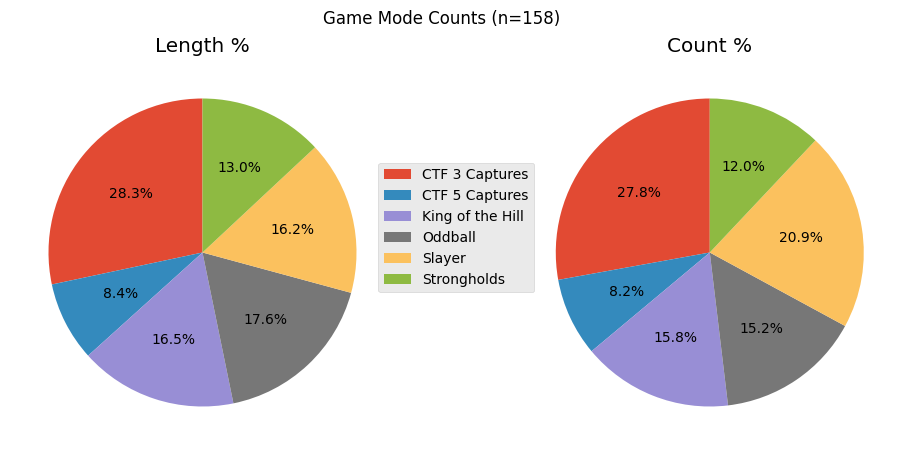

In [13]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
# Update the title of the plot to include the total game count
fig.suptitle(f'Game Mode Counts (n={totalcount})')

ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")

plt.show()

In [14]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)


print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Totals
Total Games: 158
Total Kills: 2332
Total Deaths: 2027
Total Assists: 1406
----------------------------
Overall
Overall KD: 1.18
Average Kills: 13.49
Average Deaths: 11.43
Average Assists: 8.25
Average Accuracy: 52.7
Average Damage Done: 5455
Average Damage Taken: 4563
Damage Ratio: 1.2
Win-Loss: 94-63
----------------------------
Wins
Overall KD: 1.35
Average Kills: 14.13
Average Deaths: 10.5
Average Assists: 8.86
Average Accuracy: 53.54
Average Damage Done: 5294
Average Damage Taken: 4191
Damage Ratio: 1.26
Wins: 94
----------------------------
Losses
Overall KD: 0.98
Average Kills: 12.51
Average Deaths: 12.79
Average Assists: 7.36
Average Accuracy: 51.72
Average Damage Done: 5660
Average Damage Taken: 5065
Damage Ratio: 1.12
Losses: 63


In [15]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 1.0150417499971809s
